In [179]:
import numpy as np

# from ces import CES
from utils.figures import serve_CES_plot
from math import isnan

import control as ct
import control.optimal as obc
import scipy.optimize as sciop
import matplotlib.pyplot as plt

Summary statistics:
* Cost function calls: 56
* Constraint calls: 114
* Eqconst calls: 114
* System simulations: 1
* Final cost: 193.43750000000003


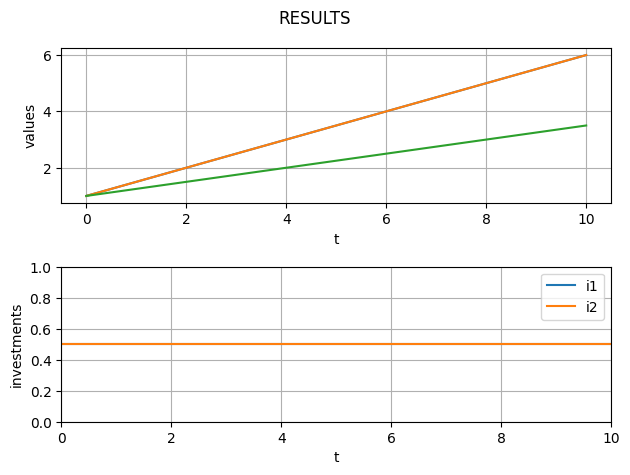

In [195]:
class CES:
    ''' Implementation of a CES 
    '''

    def __init__(self, alpha1, alpha2, rho):
      self.alpha1 = alpha1
      self.alpha2 = alpha2
      self.rho = rho
      self.elast = 1 / (1 - rho) if rho != 1 else None

    # EVALUATION FUNCTIONS

    def eval(self, x1, x2):
      if self.rho != 0:
        return (
                self.alpha1 * (x1 ** self.rho)
              + self.alpha2 * (x2 ** self.rho)
                ) ** (1/self.rho)
      else:
        return 1

    def eval_derivatives(self, x1, x2):
      if self.rho != 0:
        res_eval = self.eval(x1, x2)
        denom = self.alpha1 * (x1 ** self.rho) + self.alpha2 * (x2 ** self.rho)

        return (self.alpha1 * res_eval * self.alpha1 * (x1 ** (self.rho - 1)) / denom,
                self.alpha2 * res_eval * self.alpha1 * (x2 ** (self.rho - 1)) / denom)

      else:
        return 0

    # EVALUATION FUNCTIONS

    def update_function(self,t,x,u,params):
        p1 = params.get('p1')
        p2 = params.get('p2')
        x1_0 = params.get('x1_0')
        x2_0 = params.get('x2_0') 
        
        dydx1, dydx2 = self.eval_derivatives(x[0] + x1_0, x[1]+x2_0)
        
        if isnan(dydx1):
            dydx1 = 0

        if isnan(dydx2):
            dydx2 = 0

        dx1dt, dx2dt = u[0] / p1, u[1] / p2

        return np.array([dx1dt, dx2dt, (dydx1 * dx1dt + dydx2 * dx2dt)])
    
    def output_function(self,t,x,u,params):
      x1_0 = params.get('x1_0')
      x2_0 = params.get('x2_0') 
      # Todo: set initial conditions for x[2] 
      return np.array([x[0] + x1_0, x[1] + x2_0, x[2]+1])


class ControlProblem:
    def __init__(self, rho=-2, q0=np.array([1.,1.]), p=np.array([1.,1.]), I=1., Tf=10):

        self.x0 = np.array([q0[0],
                      q0[1],
                      q0[0] * p[0] + q0[1] * p[1]])
        
        self.params = {
            'p1': p[0],
            'p2': p[1],
            'x1_0' : q0[0],
            'x2_0' : q0[1],
        }
    
        self.ces = CES(self.x0[0] / self.x0[2], self.x0[1] / self.x0[2], rho)
    
        self.dynamic =  ct.NonlinearIOSystem(
              self.ces.update_function, 
              self.ces.output_function,
              states=3, name='investment',
              inputs=('i1', 'i2'), outputs=('x1','x2','y'), params=self.params)
    
        self.I = I
        self.Tf = Tf
    
        self.constraints = [obc.input_range_constraint(self.dynamic, [0.1, 0.1], [self.I, self.I]),
                           sciop.LinearConstraint(np.array([[0, 0, 0, p[0], p[1]]]), self.I, self.I)]
    
        self.cost = obc.quadratic_cost(self.dynamic, Q=np.diag([1,1,1]), R=np.diag([1,1])) # 0 0 1 0 0
        
        self.timepts = np.linspace(0, Tf, 11, endpoint=True)

            
    def solve(self):
        self.result = obc.solve_ocp(
             self.dynamic,
             timepts=self.timepts,
             X0=0, # bug : x0 seems not to be taken in account
             initial_guess=np.array([self.I/2, self.I/2]),
             cost=self.cost,
             trajectory_constraints=self.constraints,
             )

    def plot_results(self):
        resp = ct.input_output_response(
            self.dynamic, self.timepts, self.result.inputs,
            t_eval=self.timepts)

        t, y, u = resp.time, resp.outputs, resp.inputs

        plt.subplot(2, 1, 1)
        plt.plot(t, y[0], label='x1')
        plt.plot(t, y[1], label='x2')
        plt.plot(t, y[2], label='y')
        plt.xlabel("t")
        plt.ylabel("values")
        plt.grid(True)
        
        plt.subplot(2, 1, 2)
        plt.plot(t, u[0], label='i1')
        plt.plot(t, u[1], label='i2')
        plt.axis([0, 10, 0, 1])
        plt.xlabel("t")
        plt.ylabel("investments")
        plt.grid(True)

        plt.suptitle("RESULTS")
        plt.tight_layout()
        plt.legend()
        plt.show()

problem = ControlProblem()
problem.solve()
problem.plot_results()

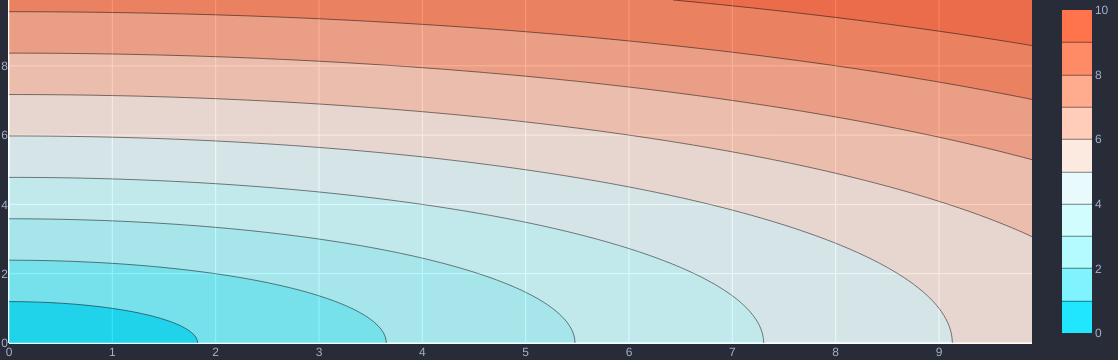

In [56]:
serve_CES_plot(0,0,10,10,ces)